<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/storgae/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sklearn
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=da2b56af2cc3a9b38d5c952d838358400bd1b229b961967c865a54e37fafeb51
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=eec57d0ade90baa1987a63ca242ed2de79ad9620534e3f0703b70b9d53a57414
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
^C


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import tensorflow as tf
import pywt
from scipy import signal
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:

def lowpass_filter(data, cutoff, order):
  nyq = 0.5 * data.shape[-1]
  b, a = signal.butter(order, cutoff/nyq, 'lowpass')
  zi = signal.lfilter_zi(b, a)
  y, _ = signal.lfilter(b, a, data, zi=zi*data[0])
  return y


def lowpass(data, fs, fc, order):
    # Define the filter parameters
    b, a = signal.butter(order, fc / (fs / 2), 'lowpass')
    # Apply the filter to the data
    y = signal.filtfilt(b, a, data)
    return y

def SamplesToFreq(x,sample_rate):
  frequency = sample_rate / x
  return frequency

def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='coif3', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')

def sliding_window(data, window_size):
    windows = []
    for i in range(len(data)):
        window = data[max(0, i-window_size+1):i+1]
        while len(window) < window_size:
            window = np.concatenate(([window[0]], window))
        windows.append(window)
    return np.array(windows)

def fill_nan_with_mean(df):
    # calculate mean of each column
    means = df.mean()
    
    # fill NaN values with mean of column
    df.fillna(means, inplace=True)
    
    return df


def sliding_windowdf(df, window_size):
    # initialize empty list to store arrays
    data = []
    
    # iterate through rows of dataframe
    for i in range(len(df)):
        # check if there are enough previous rows to create sliding window
        if i >= window_size:
            # extract values of sliding window at current time step
            window = df.iloc[i-window_size:i].values
        else:
            # pad sliding window with NaN values
            pad_width = ((window_size-i, 0), (0, 0))
            window = np.pad(df.iloc[0:i].values, pad_width, mode='constant', constant_values=np.nan)
            # calculate mean of each column and fill NaN values with mean
            means = pd.DataFrame(window).mean()
            window = pd.DataFrame(window).fillna(value=means).values
        # add window to list of arrays
        data.append(window)
    
    # convert list of arrays to numpy array
    data = np.array(data)
    
    return data

def replace_nan_with_zero(arr):
  arr[np.isnan(arr)] = 0
  return arr
def calculate_relative_change(arr):
    # shift array by one to get old array
    old_arr = np.roll(arr, 1)
    old_arr[0] = arr[0] # set first value to first number in array
    # calculate relative change
    relative_change = (arr - old_arr) / old_arr
    return relative_change

def scale_array(arr):
    scaled_arr = (arr - arr.min()) / (arr.max() - arr.min())
    return scaled_arr

/usr/local/lib/python3.10/dist-packages/pywt/_utils.py:15: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/usr/local/lib/python3.10/dist-packages/pywt/_utils.py:15: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/usr/local/lib/python3.10/dist-packages/pywt/_utils.py:15: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the ba

93084


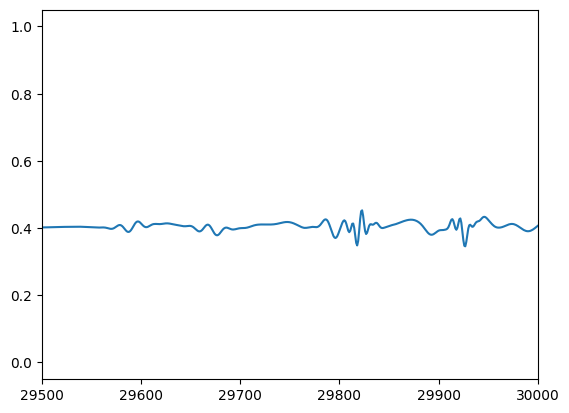

In [7]:

data = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
data.dropna()
close = data.pop('BC')

data.pop('Date')
data.pop('Time')
data = (data-data.min())/(data.max()-data.min())

for wav in pywt.wavelist():
    try:
        filtered = wavelet_denoising(close, wavelet=wav, level=2)
    except:
        pass
    

sma = ta.sma(close,10)
sma1 = ta.sma(close,20)
sma2 = ta.sma(close,30)
sma3 = ta.sma(close,40)

closemeanrmv1 = np.subtract(sma,close)
closemeanrmv2 = np.subtract(sma1,close)
closemeanrmv3 = np.subtract(sma2,close)
closemeanrmv4 = np.subtract(sma3,close)


target = (filtered-filtered.min())/(filtered.max()-filtered.min())


#window = sliding_window(data,3)
new = np.column_stack((sma,closemeanrmv1,closemeanrmv2,closemeanrmv3,closemeanrmv4))

df = pd.DataFrame(new, columns=['A', 'B', 'C','e', 'f'])

ROC = calculate_relative_change(filtered)
ROC = scale_array(ROC)


new = fill_nan_with_mean(df)


window = sliding_windowdf(new,10)
window = replace_nan_with_zero(window)
#print(np.isnan(window))
#window_size = 100
#windows = sliding_window(close, window_size)
#print(windows)

#plt.plot(close)
plt.plot(ROC)
#plt.plot(filtered)
#print(data)
plt.xlim(29500,30000)
#plt.ylim(1.5,1.7)
print(len(window))

#print(window)

In [30]:
from keras.regularizers import Regularizer
reg = tf.keras.regularizers.L2(l2=0.01)
opti = tf.keras.optimizers.Adam(.01)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=7, strides=1, padding="causal", activation="relu"),
  tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1, padding="causal", activation="relu"),
  tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding="causal", activation="relu"),
  tf.keras.layers.Conv1D(filters=12, kernel_size=7, strides=1, padding="causal", activation="relu"),
  tf.keras.layers.Dense(1)
])
loss_fn = tf.keras.losses.MeanAbsoluteError()
model.compile(optimizer=opti,
              loss=loss_fn,
              metrics=['RootMeanSquaredError'])

In [28]:


hist = model.fit(window, ROC, epochs=10, batch_size=64)

Epoch 1/10
1455/1455 [==============================] - 30s 20ms/step - loss: 0.0099 - root_mean_squared_error: 0.0285
Epoch 2/10
1455/1455 [==============================] - 27s 19ms/step - loss: 0.0079 - root_mean_squared_error: 0.0137
Epoch 3/10
1455/1455 [==============================] - 25s 17ms/step - loss: 0.0078 - root_mean_squared_error: 0.0136
Epoch 4/10
1455/1455 [==============================] - 29s 20ms/step - loss: 0.0078 - root_mean_squared_error: 0.0136
Epoch 5/10
1455/1455 [==============================] - 27s 19ms/step - loss: 0.0077 - root_mean_squared_error: 0.0136
Epoch 6/10
1455/1455 [==============================] - 28s 19ms/step - loss: 0.0077 - root_mean_squared_error: 0.0136
Epoch 7/10
1455/1455 [==============================] - 27s 19ms/step - loss: 0.0076 - root_mean_squared_error: 0.0135
Epoch 8/10
1455/1455 [==============================] - 25s 17ms/step - loss: 0.0076 - root_mean_squared_error: 0.0135
Epoch 9/10
1455/1455 [==========================

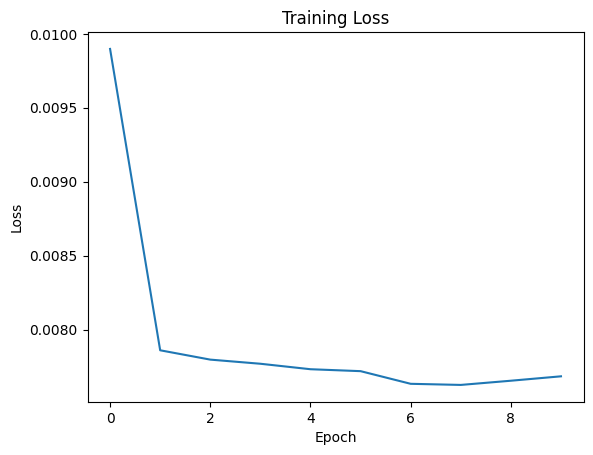

In [31]:
# Plot the training loss
plt.plot(hist.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [32]:
prediction = model.predict(window)

2909/2909 [==============================] - 11s 4ms/step


ValueError: ignored

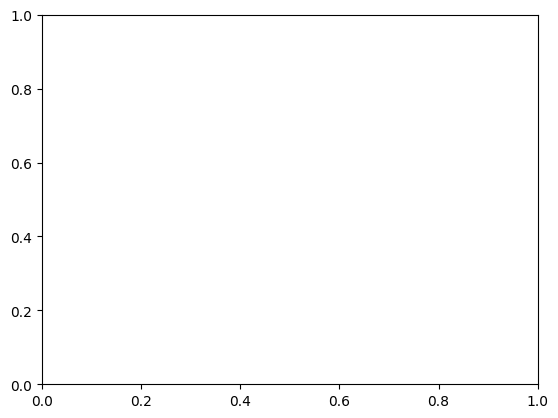

In [33]:

plt.plot(prediction)
plt.plot(ROC)
plt.xlim(20000,20900)
plt.ylim(.3,.5)